# ResNet-50 training from scratch on Animal-10 Dataset

This this notebook, we implement ResNet-50 from scratch and train it on animals dataset. The dataset is can be found on Kaggle: https://www.kaggle.com/datasets/alessiocorrado99/animals10

In [1]:
import torch
import torch.nn as nn
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np
from torchinfo import summary
from tqdm import tqdm

c:\Users\bader\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
imgs_path = Path("data/animals-10/raw-img")
class_to_idx = {p.name: i for i, p in enumerate(list((imgs_path).iterdir()))}
idx_to_class = {v:k for k,v in class_to_idx.items()}

In [4]:
class AnimalDataset(Dataset):
    def __init__(self, imgs_path, transform = None) -> None:
        self.imgs_path = imgs_path
        self.transform = transform

        self.files_paths = [p for p in imgs_path.glob("**/*") if p.is_file()]

    def __len__(self):
        return len(self.files_paths)
    
    def __getitem__(self, index):
        file_path = self.files_paths[index]
        img = Image.open(file_path).convert('RGB')
        label = file_path.parent.name
        label = class_to_idx[label]

        if self.transform:
            img = self.transform(img)
        
        return img, label


In [5]:
def get_loaders(imgs_path, batch_size, val_split = 0.1, test_split=0.1, shuffle = True, random_seed=42):

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

    
    train_dataset = AnimalDataset(imgs_path, train_transform)
    val_dataset = AnimalDataset(imgs_path, val_transforms)
    test_dataset = AnimalDataset(imgs_path, val_transforms)

    len_train = int(np.floor(len(train_dataset) * (1 - val_split - test_split)))
    len_val = int(np.floor(len(train_dataset) * val_split))
    len_test = len(train_dataset) - len_val - len_train

    indices = list(range(len(train_dataset)))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, val_idx, test_idx = indices[:len_train], indices[len_train:len_train + len_val], indices[len_train + len_val:]

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    train_loader = DataLoader(train_dataset, batch_size, train_sampler)
    val_loader = DataLoader(val_dataset, batch_size, val_sampler)
    test_loader = DataLoader(test_dataset, batch_size, test_sampler)
                               
    return train_loader, val_loader, test_loader


Display images from the dataset

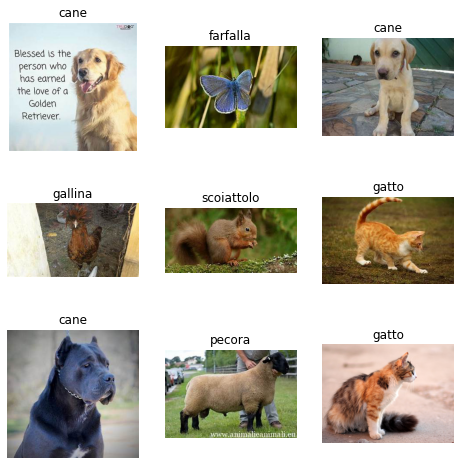

In [6]:
ds = AnimalDataset(imgs_path)

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, rows * cols + 1):
    sample_idx = torch.randint(len(ds), size=(1,)).item()
    img, label = ds[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(idx_to_class[label])
    plt.axis("off")
    plt.imshow(img)

plt.show()

Create data loaders

In [7]:
batch_size = 64

In [8]:
train_loader, val_loader, test_loader = get_loaders(imgs_path, batch_size)

## Create ResNet-50

In [9]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, shortcut, stride) -> None:
        super().__init__()

        if shortcut:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )
            self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, padding=0)
        else:
            self.shortcut = nn.Sequential()
            self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, padding=0)


        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu3 = nn.ReLU()

    def forward(self, x):

        shortcut = self.shortcut(x)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))

        return self.relu3(x + shortcut)

In [10]:
class ResNet50(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super().__init__()

        self.layer0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            ResBlock(64, 64, 256, True, 1),
            ResBlock(256, 64, 256, False, 1),
            ResBlock(256, 64, 256, False, 1),
        )

        self.layer2 = nn.Sequential(
            ResBlock(256, 128, 512, True, 2),
            ResBlock(512, 128, 512, False, 1),
            ResBlock(512, 128, 512, False, 1),
            ResBlock(512, 128, 512, False, 1),
        )

        self.layer3 = nn.Sequential(
            ResBlock(512, 256, 1024, True, 2),
            ResBlock(1024, 256, 1024, False, 1),
            ResBlock(1024, 256, 1024, False, 1),
            ResBlock(1024, 256, 1024, False, 1),
            ResBlock(1024, 256, 1024, False, 1),
            ResBlock(1024, 256, 1024, False, 1),
        )

        self.layer4 = nn.Sequential(
            ResBlock(1024, 512, 2048, True, 2),
            ResBlock(2048, 512, 2048, False, 1),
            ResBlock(2048, 512, 2048, False, 1)
        )


        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, num_classes)


    def forward(self, x):

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.gap(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x


In [11]:
num_classes = len(class_to_idx)

In [12]:
model = ResNet50(num_classes)

In [13]:
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet50                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,472
│    └─MaxPool2d: 2-2                    [1, 64, 56, 56]           --
│    └─BatchNorm2d: 2-3                  [1, 64, 56, 56]           128
│    └─ReLU: 2-4                         [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─ResBlock: 2-5                     [1, 256, 56, 56]          --
│    │    └─Sequential: 3-1              [1, 256, 56, 56]          17,152
│    │    └─Conv2d: 3-2                  [1, 64, 56, 56]           4,160
│    │    └─BatchNorm2d: 3-3             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-4                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 64, 56, 56]           36,928

## Train model

In [14]:
num_epochs = 20
learning_rate = 0.005
weight_decay_rate = 0.0005
momentum = 0.9

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate, momentum=momentum)

In [16]:
total_steps = len(train_loader)

In [17]:
for epoch in range(num_epochs):
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    print(f"Epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.4f}")

    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)

            correct += (preds == labels).sum()
            total += labels.size(0)

        acc = 100 * correct / total

    print(f"Validation accuracy: {acc:.2f}%")

100%|██████████| 410/410 [03:30<00:00,  1.95it/s]


Epoch [1/20], loss: 2.3144
Validation accuracy: 30.63%


100%|██████████| 410/410 [03:14<00:00,  2.11it/s]


Epoch [2/20], loss: 3.0911
Validation accuracy: 44.46%


100%|██████████| 410/410 [03:00<00:00,  2.28it/s]


Epoch [3/20], loss: 2.0914
Validation accuracy: 55.41%


100%|██████████| 410/410 [03:01<00:00,  2.26it/s]


Epoch [4/20], loss: 3.9521
Validation accuracy: 51.88%


100%|██████████| 410/410 [03:06<00:00,  2.20it/s]


Epoch [5/20], loss: 0.4622
Validation accuracy: 66.81%


100%|██████████| 410/410 [03:09<00:00,  2.17it/s]


Epoch [6/20], loss: 0.8852
Validation accuracy: 66.90%


100%|██████████| 410/410 [03:10<00:00,  2.16it/s]


Epoch [7/20], loss: 2.6600
Validation accuracy: 71.62%


100%|██████████| 410/410 [03:06<00:00,  2.19it/s]


Epoch [8/20], loss: 2.0765
Validation accuracy: 76.67%


100%|██████████| 410/410 [03:07<00:00,  2.19it/s]


Epoch [9/20], loss: 1.3793
Validation accuracy: 78.12%


100%|██████████| 410/410 [03:06<00:00,  2.20it/s]


Epoch [10/20], loss: 0.5783
Validation accuracy: 83.34%


100%|██████████| 410/410 [03:05<00:00,  2.21it/s]


Epoch [11/20], loss: 0.0900
Validation accuracy: 85.15%


100%|██████████| 410/410 [03:02<00:00,  2.24it/s]


Epoch [12/20], loss: 0.6077
Validation accuracy: 86.16%


100%|██████████| 410/410 [03:06<00:00,  2.20it/s]


Epoch [13/20], loss: 1.4404
Validation accuracy: 86.16%


100%|██████████| 410/410 [03:05<00:00,  2.21it/s]


Epoch [14/20], loss: 1.4898
Validation accuracy: 89.08%


100%|██████████| 410/410 [03:06<00:00,  2.20it/s]


Epoch [15/20], loss: 2.5917
Validation accuracy: 90.21%


100%|██████████| 410/410 [03:04<00:00,  2.22it/s]


Epoch [16/20], loss: 1.7058
Validation accuracy: 88.88%


100%|██████████| 410/410 [03:04<00:00,  2.22it/s]


Epoch [17/20], loss: 2.4858
Validation accuracy: 93.08%


100%|██████████| 410/410 [03:07<00:00,  2.19it/s]


Epoch [18/20], loss: 0.2842
Validation accuracy: 93.27%


100%|██████████| 410/410 [03:09<00:00,  2.16it/s]


Epoch [19/20], loss: 2.4279
Validation accuracy: 93.59%


100%|██████████| 410/410 [03:15<00:00,  2.10it/s]


Epoch [20/20], loss: 0.7552
Validation accuracy: 92.20%


In [18]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print(f'Test accuracy: {100 * correct / total:.2f} %')

Test accuracy: 92.65 %
